In [1]:
!apt install swig xvfb
!pip install -U setuptools pyvirtualdisplay ez_setup gymnasium gymnasium[box2d]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 swig4.0 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 swig swig4.0 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 11 newly installed, 0 to remove and 49 not upgraded.
Need to get 8,930 kB of archives.
After this operation, 17.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive

In [1]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
environment_name = "LunarLander-v3"
env = gym.make(environment_name, render_mode="rgb_array")
trigger = lambda t: True
recording_env = RecordVideo(env, "./checkpoint_videos", episode_trigger=trigger)

In [5]:
observation = recording_env.reset()
while (1 == 1):
    recording_env.render()
    action = recording_env.action_space.sample()
    obs, reward, terminated, truncated, info = recording_env.step(action)
    if terminated or truncated:
        break
recording_env.close()

In [6]:
import os
import re

def get_latest_episode_video_file(directory):
    pattern = re.compile(r"rl-video-episode-(\d+)\.mp4")
    latest_file = None
    highest_episode = -1

    for filename in os.listdir(directory):
        match = pattern.match(filename)
        if match:
            episode_number = int(match.group(1))
            if episode_number > highest_episode:
                highest_episode = episode_number
                latest_file = os.path.join(directory, filename)

    return latest_file

latest_file = get_latest_episode_video_file("./checkpoint_videos")
print(latest_file) #./checkpoint_videos/rl-video-episode-n.mp4

./checkpoint_videos/rl-video-episode-0.mp4


In [16]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(2800, 1800))
display.start()

import io
import base64

from IPython import display
from IPython.display import HTML
def embed_video(video_file):
    video_data = io.open(video_file, 'r+b').read()
    encoded_data = base64.b64encode(video_data)
    display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded_data.decode('ascii'))))
embed_video(latest_file)
#run after new video made

FileNotFoundError: [Errno 2] No such file or directory: './checkpoint_videos/rl-video-episode-0.mp4'

In [8]:
import torch.nn as nn
import torch.nn.functional as Func
import torch.optim as optim
import torch
import numpy as np
from torch.optim import AdamW
from torch.nn import MSELoss
class AgentNetwork(nn.Module):
    def __init__(self, n_actions, input_shape):
        super(AgentNetwork, self).__init__()
        self.n_actions = n_actions
        self.input_shape = input_shape
        self.fc1 = nn.Linear(input_shape, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, n_actions)
        self.device = torch.device("cpu")
    def forward(self, x):
        x = self.fc1(x)
        x = Func.relu(x)
        x = self.fc2(x)
        x = Func.relu(x)
        x = self.fc3(x)
        return x
    def get_action(self, x):
        x = self.forward(x)
        return torch.argmax(x)
    def to(self, device):
        self.device = device
        return super().to(device)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent_network = AgentNetwork((env.action_space.n), env.observation_space.shape[0]).to(device)
learning_rate = 0.001
optimizer = AdamW(agent_network.parameters(), weight_decay=0.01, lr=learning_rate)
loss_fn = MSELoss()

In [9]:
from dataclasses import dataclass
@dataclass
class ReplayBufferSample:
    state: any
    action: any
    reward: float
    new_state: any
    was_terminal: bool

import random
from collections import deque
from typing import List
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def add_replay_buffer_sample(self, element: ReplayBufferSample):
        self.buffer.append(element)

    def add_new_sample(self, state, action, reward, new_state, was_terminal):
        sample = ReplayBufferSample(state, action, reward, new_state, was_terminal)
        self.add_replay_buffer_sample(sample)

    def sample_buffer(self, batch_size: int) -> List[ReplayBufferSample]:
        samples = random.sample(self.buffer, batch_size)
        return samples
    def get_pytorch_training_samples(self, device, learning_batch_size):
        samples = self.sample_buffer(learning_batch_size)
        states = torch.tensor([s.state for s in samples], dtype=torch.float32).to(device)
        actions = torch.tensor([s.action for s in samples]).to(device)
        rewards = torch.tensor([s.reward for s in samples], dtype=torch.float32).to(device)
        new_states = torch.tensor([s.new_state for s in samples], dtype=torch.float32).to(device)
        was_terminals = torch.tensor([s.was_terminal for s in samples]).to(device)
        return states, actions, rewards, new_states, was_terminals

    def __len__(self):
        return len(self.buffer)

In [10]:
from gymnasium.wrappers import RecordVideo
from pathlib import Path
import matplotlib.pyplot as plt

class AgentDeepQTrainer:
    def __init__(self, env, recording_env, agent_network, loss_fn, optimizer, eps_min=0.01, eps_dec=5e-6, replay_buffer_size=100000, learning_batch_size=64, checkpoint_dir="./checkpoints", replace_target_count=500, future_discount=0.99, print_status_steps=100):
        self.env = env
        self.eval_env = recording_env

        self.agent_network = agent_network
        self.target_network = type(agent_network)(self.agent_network.n_actions, self.agent_network.input_shape)
        self.target_network.load_state_dict(self.agent_network.state_dict())
        self.target_network = self.target_network.to(self.agent_network.device)

        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.epsilon = 1
        self.epsilon_min = eps_min
        self.epsilon_decrement=eps_dec

        self.checkpoint_dir = checkpoint_dir
        Path(self.checkpoint_dir).mkdir(parents=True, exist_ok=True)

        self.replace_target_count = replace_target_count
        self.replay_buffer = ReplayBuffer(replay_buffer_size)
        self.learn_step_counter = 0
        self.future_discount = future_discount
        self.learning_batch_size = learning_batch_size
        self.print_status_steps=print_status_steps

        self.training_rewards = []
        self.eval_rewards = []
    def should_replace_target_network(self):
        return self.learn_step_counter % self.replace_target_count == 0
    def replace_target_network(self):
        self.target_network.load_state_dict(self.agent_network.state_dict())
    def choose_action_with_epsilon(self, observation):
        if np.random.random() > self.epsilon:
            with torch.no_grad():
                observation = torch.tensor([observation], dtype=torch.float).to(self.agent_network.device)
                return self.agent_network.get_action(observation).item()

        return self.env.action_space.sample()
    def decrement_epsilon(self):
        self.epsilon = max(self.epsilon - self.epsilon_decrement, self.epsilon_min)


    def learn_step(self):
        if len(self.replay_buffer) <= self.learning_batch_size:
            return
        if self.should_replace_target_network():
            self.replace_target_network()
        self.optimizer.zero_grad()
        samples = self.replay_buffer.get_pytorch_training_samples(self.agent_network.device, self.learning_batch_size)
        states, actions, rewards, new_states, was_terminals = samples

        indices = np.arange(self.learning_batch_size)
        q_pred = self.agent_network.forward(states)[indices, actions]
        q_next = self.target_network.forward(new_states).max(dim=1)[0]
        q_next[was_terminals] = 0.0

        q_label = rewards + self.future_discount * q_next

        loss = self.loss_fn(q_label, q_pred).to(self.agent_network.device)
        loss.backward()
        self.optimizer.step()
        self.learn_step_counter += 1
        self.decrement_epsilon()

    def run_eval_episode(self):
        state = self.eval_env.reset()[0]
        done = False
        truncated = False
        eval_reward = 0
        step = 0
        with torch.no_grad():
            while not done and not truncated:
                step += 1
                self.eval_env.render()

                state = torch.tensor([state], dtype=torch.float).to(self.agent_network.device)
                action = self.agent_network.get_action(state).item()
                state, reward, done, truncated, _ = self.eval_env.step(action)
                eval_reward += reward
        self.eval_env.close()
        return eval_reward

    def run_train_episode(self):
        state = self.env.reset()[0]
        done = False
        truncated = False
        total_reward = 0
        while not done and not truncated:
            action = self.choose_action_with_epsilon(state)
            new_state, reward, done, truncated, _ = self.env.step(action)
            self.replay_buffer.add_new_sample(state, action, reward, new_state, done)
            state = new_state
            total_reward += reward
            self.learn_step()

        return total_reward
    def save_model(self, file_path):
        torch.save(self.agent_network, file_path)

    def save_episode_checkpoint_model(self, episode_num):
        file_name = self.checkpoint_dir+"/eval_episode=%s.pth"%episode_num
        self.save_model(file_name)
    def train(self, num_episodes):
        training_rewards = []
        for episode in range(num_episodes+1):
            training_reward = self.run_train_episode()
            training_rewards.append(training_reward)

            if (episode%self.print_status_steps==0):
                self.save_episode_checkpoint_model(episode)
                eval_reward = self.run_eval_episode()
                self.eval_rewards.append(eval_reward)

                average_training_rewards = sum(training_rewards)/(len(training_rewards)+1)
                self.training_rewards.append(average_training_rewards)
                training_rewards = []
                print(f"Episode {episode+1}/{num_episodes}, Average Training Reward: {average_training_rewards}, Epsilon: {self.epsilon:.4f}, Training steps: {self.learn_step_counter}, Eval reward: {eval_reward}")

    def plot_rewards(self):
        episodes = [i*self.print_status_steps for i in range(0, len(self.training_rewards))]

        print(self.eval_rewards[self.num_episodes + 1])
        plt.plot(episodes, self.eval_rewards, label="Evaluation Rewards")
        plt.xlabel("Episodes")
        plt.ylabel("Reward")
        plt.title("Evaluation Rewards Over Episodes")
        plt.legend()
        plt.show()

Episode 1/1000, Average Training Reward: -72.20979657946631, Epsilon: 0.9999, Training steps: 19, Eval reward: -144.56178560376608
Episode 101/1000, Average Training Reward: -148.5646966594712, Epsilon: 0.9511, Training steps: 9773, Eval reward: 266.70207799157316
Episode 201/1000, Average Training Reward: -133.03345320736898, Epsilon: 0.9040, Training steps: 19200, Eval reward: 26.809358520340524
Episode 301/1000, Average Training Reward: -121.14513709927108, Epsilon: 0.8547, Training steps: 29063, Eval reward: -4.464011315074046
Episode 401/1000, Average Training Reward: -97.8287893474702, Epsilon: 0.8065, Training steps: 38700, Eval reward: -292.36092405399916
Episode 501/1000, Average Training Reward: -104.77344200917275, Epsilon: 0.7558, Training steps: 48846, Eval reward: -107.5611594358556
Episode 601/1000, Average Training Reward: -87.7438321619702, Epsilon: 0.7027, Training steps: 59466, Eval reward: -61.29500419350886
Episode 701/1000, Average Training Reward: -67.29425088956

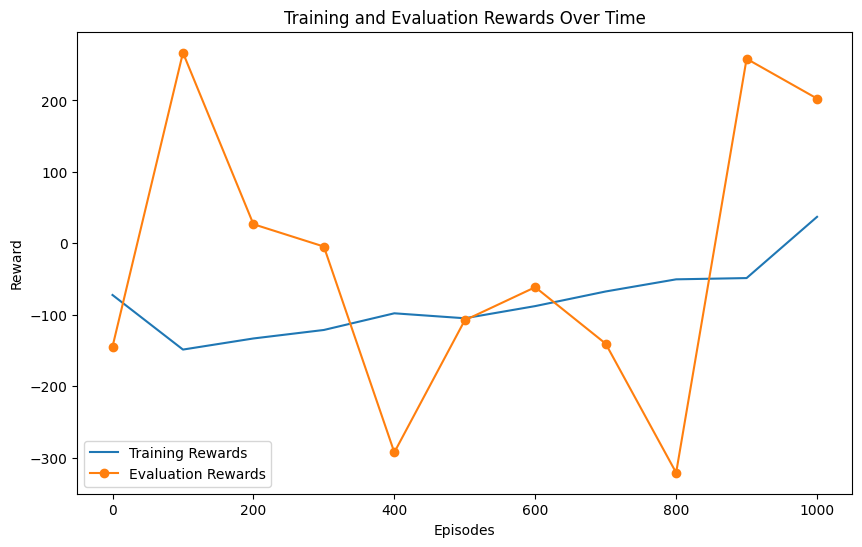

In [14]:
trainer = AgentDeepQTrainer(env, recording_env, agent_network, loss_fn, optimizer)
trainer.train(2000)
trainer.plot_rewards()